# Baseline Model Evaluation
- on the augmented PaHaW dataset
- exclude pretrained weights
- **goal**: compare baseline results with models pretrained using transfer learning and trained using supervised contrastive learning

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn utilities
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Import PyTorch utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet50

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    print("Google Colab not detected, skipping drive mounting.")

# Set up plotting styles
sns.set()
plt.style.use('ggplot')

Mounted at /content/drive


## Data Preprocessing and Feature Extraction using ResNet50

In [2]:
# Preprocessing steps for the input images:
# 1. Resize the image to a larger size.
# 2. Crop the center region to the target size.
# 3. Convert the image to a tensor.
# 4. Normalize the image using mean and standard deviation values for each channel.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the ResNet50 model for feature extraction.
# Use pre-trained weights from the ImageNet dataset.
# Replace the fully connected (fc) layer with an identity layer to get raw features.
resnet = models.resnet50(weights=None)
resnet.fc = torch.nn.Identity()
resnet.eval()  # Set the model to evaluation mode.

# Move the model to GPU if available for faster processing.
if torch.cuda.is_available():
    resnet.cuda()

# Function to load image data from a directory and create a DataLoader object.
# The images are loaded using a specified transform (preprocess).
def load_data(directory):
    dataset = datasets.ImageFolder(directory, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
    return dataloader

# Function to extract features from images using the ResNet model.
# Takes a DataLoader object and returns features and labels.
def extract_features(dataloader):
    features = []  # List to store extracted features.
    labels = []  # List to store corresponding labels.
    with torch.no_grad():  # Disable gradient computation for efficient inference.
        for inputs, label_batch in dataloader:
            # Move data to GPU if available.
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            # Extract features and move them to the CPU.
            feature_batch = resnet(inputs)
            features.extend(feature_batch.cpu().numpy())
            labels.extend(label_batch.numpy())
    return features, labels

In [3]:
# Load data from the directory containing labeled images.
dataloader = load_data('/content/drive/MyDrive/complete_data')
# Extract features using the ResNet model.
features, labels = extract_features(dataloader)

# Split the features based on label values.
pd_features = [feature for feature, label in zip(features, labels) if label == 0]
health_features = [feature for feature, label in zip(features, labels) if label == 1]

# Print dataset information for verification.
print(dataloader.dataset.classes)
print(len(health_features))
print(len(features))

['test', 'train']
346
432


## Model Evaluation using Logistic Regression

1. Accuracy: 0.5862
2. Precision: 0.6761
3. Recall: 0.7869
4. F1 Score: 0.7273


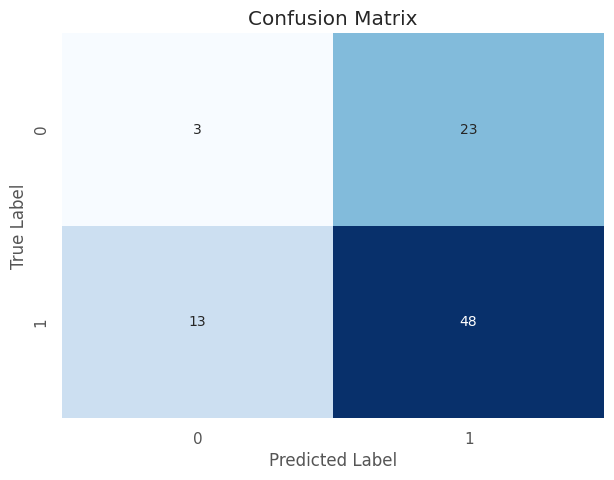

<ipython-input-4-f1e0da567445>:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(base_fpr, fpr, tpr)


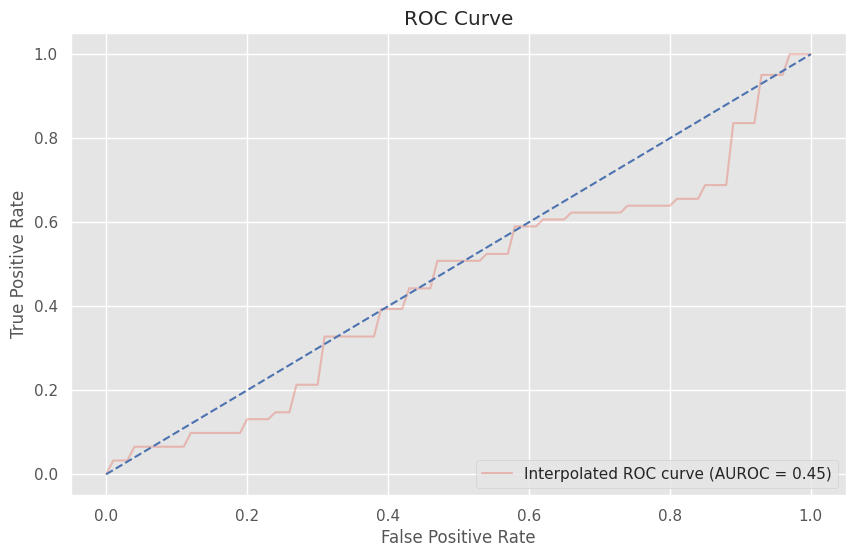

5. AUROC Value: 0.4515


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from scipy import interp
from numpy import linspace

# Convert lists to NumPy arrays for feature-label splitting.
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets.
# Using an 80-20 split and a fixed random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Initialize and train the logistic regression model.
# Using `max_iter` to ensure convergence.
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Predict the labels and probabilities for the test set.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate performance metrics: Accuracy, Precision, Recall, and F1 Score.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics for the test set.
print(f'1. Accuracy: {accuracy:.4f}')
print(f'2. Precision: {precision:.4f}')
print(f'3. Recall: {recall:.4f}')
print(f'4. F1 Score: {f1:.4f}')

# Generate and display the Confusion Matrix as a heatmap.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate the Area Under the ROC Curve (AUROC).
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute the ROC curve and interpolate it for smoother plotting.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
base_fpr = linspace(0, 1, 101)
interp_tpr = interp(base_fpr, fpr, tpr)
interp_tpr[0] = 0.0  # Ensure the curve starts at (0, 0).

# Plot the interpolated ROC curve.
plt.figure(figsize=(10, 6))
plt.plot(base_fpr, interp_tpr, alpha=0.3, label='Interpolated ROC curve (AUROC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the calculated AUROC value.
print(f'5. AUROC Value: {roc_auc:.4f}')

## Model Evaluation using ResNet

Epoch 1, Loss: 1.0989557157230379
Epoch 2, Loss: 1.1671773419285931
Epoch 3, Loss: 1.2304034849050745
Epoch 4, Loss: 0.9859562800142073
Epoch 5, Loss: 0.8282728481438311
Epoch 6, Loss: 0.7520689589142714
Epoch 7, Loss: 0.9607688193958809
Epoch 8, Loss: 0.7685916154744403
Epoch 9, Loss: 0.9147974568748333
Epoch 10, Loss: 0.8636452376373492
Epoch 11, Loss: 0.6875822054350684
Epoch 12, Loss: 1.0218405312970253
Epoch 13, Loss: 0.5193967024799725
Epoch 14, Loss: 0.6326431124210197
Epoch 15, Loss: 0.698525194343629
Epoch 16, Loss: 0.5990081125891756
Epoch 17, Loss: 0.9207524063116496
Epoch 18, Loss: 0.4915336024701253
Epoch 19, Loss: 0.5218630137200329
Epoch 20, Loss: 0.4624888629267185
Epoch 21, Loss: 0.4865977856726653
Epoch 22, Loss: 0.6012498138528638
Epoch 23, Loss: 0.5039553533190455
Epoch 24, Loss: 0.4127722565999961
Epoch 25, Loss: 0.5818723182209993
Epoch 26, Loss: 0.5915642595401164
Epoch 27, Loss: 0.6398402579977102
Epoch 28, Loss: 0.7448158089767997
Epoch 29, Loss: 0.302874079550

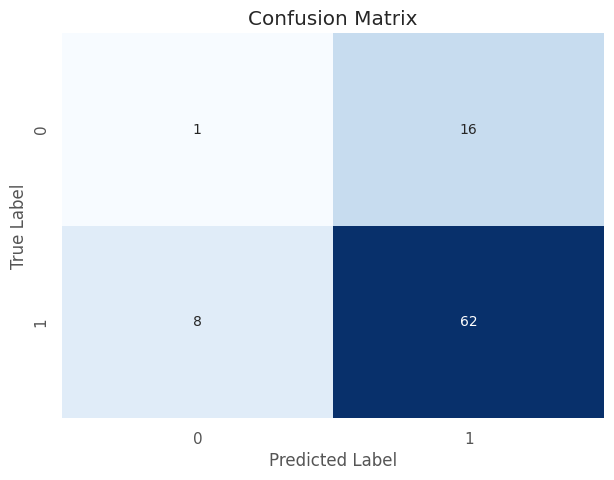

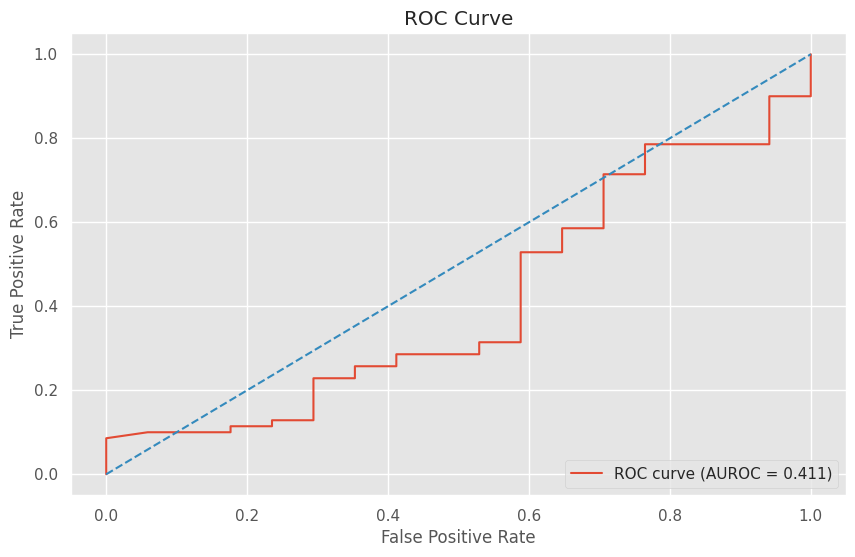

5. AUROC Value: 0.4113


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing steps:
# 1. Resize image to 256 pixels on the shorter side.
# 2. Crop the center region to 224x224 pixels.
# 3. Convert the image to a tensor.
# 4. Normalize with mean and standard deviation.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder.
dataset_path = '/content/drive/MyDrive/complete_data'
dataset = datasets.ImageFolder(dataset_path, transform=preprocess)

# Split the dataset into training and validation sets using indices.
# Maintain the same label distribution using `stratify`.
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.targets
)
train_dataset = Subset(dataset, indices=train_indices)
val_dataset = Subset(dataset, indices=val_indices)

# Create DataLoader objects for training and validation datasets.
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model setup:
# Initialize the ResNet50 model without pre-trained weights.
# Replace the last layer with a new fully connected layer (2 classes).
resnet = models.resnet50(weights=None)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available.
if torch.cuda.is_available():
    resnet = resnet.cuda()

# Loss and optimizer setup:
# Use CrossEntropyLoss for classification and SGD with momentum for optimization.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop:
num_epochs = 50
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Move inputs and labels to the GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients before each update.
        optimizer.zero_grad()

        # Forward pass and calculate the loss.
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        # Backward pass to compute gradients and update parameters.
        loss.backward()
        optimizer.step()

        # Accumulate the loss for the current epoch.
        running_loss += loss.item()

    # Print the average loss for this epoch.
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Finished Training')

# Function to evaluate the model's performance on a given DataLoader.
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode.
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():  # Disable gradient computation for evaluation.
        for inputs, labels in dataloader:
            # Move inputs to the GPU if available.
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            # Perform a forward pass through the model to get predictions.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class.
            scores = torch.softmax(outputs, dim=1)[:, 1]  # Extract scores.

            # Store true labels, predicted labels, and scores for analysis.
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(scores.cpu().numpy())

    return y_true, y_pred, y_scores

# Evaluate the trained ResNet model using the validation DataLoader.
y_true, y_pred, y_scores = evaluate_model(resnet, val_dataloader)

# Calculate performance metrics: accuracy, precision, recall, F1 score, and ROC AUC.
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)

# Print evaluation metrics to console.
print(f'1. Accuracy: {accuracy:.4f}')
print(f'2. Precision: {precision:.4f}')
print(f'3. Recall: {recall:.4f}')
print(f'4. F1 Score: {f1:.4f}')

# Generate and visualize the Confusion Matrix.
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate and plot the ROC curve.
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print the calculated AUROC value.
print(f'5. AUROC Value: {roc_auc:.4f}')
